In [1]:
import copy
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
import keras
from keras.datasets import mnist         # библиотека базы выборок Mnist
from keras.layers import Dense, Flatten
from sklearn.metrics import classification_report, confusion_matrix
import os

# Loading data

In [2]:
# Parameters
fs = 44100                  # Hz, sampling frequency
f_size = 512                # Frame size
h_size = int(f_size/2)      # Hop size
supra_frame_duration = 0.5  # seconds
frame_num_gl = round(supra_frame_duration / (h_size/fs))
dir_HC = 'wav'+ os.sep + 'HC' + os.sep
dir_ALS = 'wav' + os.sep + 'ALS' + os.sep
directory_ALS = os.listdir(dir_ALS)
directory_HC = os.listdir(dir_HC)

In [23]:
X = np.zeros((20000,h_size,frame_num_gl))   # data
y = np.zeros((20000,1))                     # labels
X_global_index = 0
X_ids = list([])                            # IDs of the speakers
# Cycle for HC (helthy controls)
for i in range(len(directory_HC)):
    if directory_HC[i][4:]=='a.dat':
        fileName = dir_HC + directory_HC[i]
        

        X_stft = np.fromfile(dir_HC + directory_HC[i], dtype=np.half)
        X_stft = np.reshape(X_stft,(h_size, np.floor(len(X_stft)/h_size).astype(int)))
        
        # plt.subplots(dpi=150)
        # plt.pcolor(X_stft,shading='flat',cmap='jet')
        # plt.xlabel('Номер фрейма')
        # plt.ylabel('$\log(|X(k,m)|)$')
        # plt.show()

#       #Запись фрагметов спектра в трехмерный массив 
        frame_num = X_stft.shape[1]
        N_supra_frames = frame_num - frame_num_gl + 1

        # generator comprehension
        gen_range = (n * 2 for n in range(0, np.floor(N_supra_frames/2).astype(int)))
        for n in gen_range:
            X[X_global_index,:,:] = X_stft[:,n:n+frame_num_gl]
            X_ids.append(int(directory_HC[i][0:3]))
            y[X_global_index] = 0
            X_global_index = X_global_index +1
    
# Cycle for ALS (pathology)
for i in range(len(directory_ALS)):
    if directory_ALS[i][4:]=='a.dat':
        fileName = dir_ALS + directory_ALS[i]        

        X_stft = np.fromfile(dir_HC + directory_HC[i], dtype=np.half)
        X_stft = np.reshape(X_stft,(h_size, np.floor(len(X_stft)/h_size).astype(int)))

#       #Запись фрагметов спектра в трехмерный массив
        frame_num = X_stft.shape[1]
        N_supra_frames = frame_num - frame_num_gl + 1

        # generator comprehension
        gen_range = (n * 2 for n in range(0, np.floor(N_supra_frames/2).astype(int)))
        for n in gen_range:
            X[X_global_index,:,:] = X_stft[:,n:n+frame_num_gl]
            X_ids.append(int(directory_ALS[i][0:3]))
            y[X_global_index] = 1
            X_global_index = X_global_index + 1
            
inds_to_delete = np.array(range(y.shape[0]))>=X_global_index
y = np.delete(y,inds_to_delete)
X = np.delete(X,inds_to_delete, axis=0)

# Train/Test sets

In [26]:
test_subjects_ids = (8, 26, 61, 62, 94, 107) # 3 -> ALS;  3-> HC

test_inds_in_dataset = (i for i in range(len(X_ids)) if X_ids[i] in test_subjects_ids)
test_inds_in_dataset = list(test_inds_in_dataset)

train_inds_in_dataset = (i for i in range(len(X_ids)) if ~(X_ids[i] in test_subjects_ids))
train_inds_in_dataset = list(train_inds_in_dataset)

X_test  = X[test_inds_in_dataset,:,:]
y_test  = y[test_inds_in_dataset]

X_train = X[train_inds_in_dataset,:,:]
y_train = y[train_inds_in_dataset]

In [2]:
# (x_train, y_train), (x_test, y_test) = mnist.load_data()

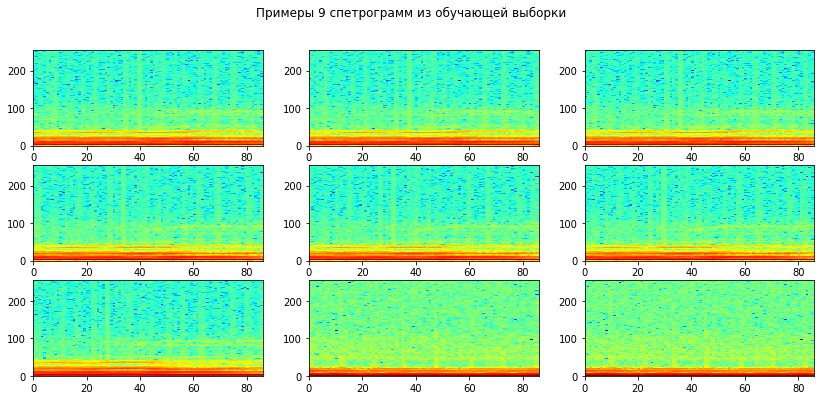

In [36]:
# отображение первых 25 изображений из обучающей выборки
f, a = plt.subplots(3, 3, figsize=(14,6))
f.suptitle('Примеры 9 спетрограмм из обучающей выборки')
for i in range(9):
    plt.subplot(3,3,i+1)
    # plt.xticks([])
    # plt.yticks([])
    # plt.imshow(X_train[i], cmap='jet')
    plt.pcolor(X_train[i+200], cmap='jet')

plt.show()

In [65]:
model = keras.Sequential([
    Flatten(input_shape=(h_size, X.shape[2])),
    Dense(1, activation='sigmoid')
])

print(model.summary())      # вывод структуры НС в консоль

model.compile(optimizer='adam',
            #  loss='mean_squared_error',
             loss=keras.losses.BinaryCrossentropy(from_logits=False),
             metrics=['accuracy', keras.metrics.Precision(), 
             keras.metrics.Recall()])

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_5 (Flatten)         (None, 22016)             0         
                                                                 
 dense_5 (Dense)             (None, 1)                 22017     
                                                                 
Total params: 22,017
Trainable params: 22,017
Non-trainable params: 0
_________________________________________________________________
None


## Train process

In [66]:
# X_tr = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2]))

epochs_num = 20

hist = model.fit(X_train, y_train, batch_size=100, epochs=epochs_num, validation_split=0.3)

Epoch 1/20
124/124 [==============================] - 2s 12ms/step - loss: 3.0733 - accuracy: 0.6716 - precision_1: 0.4012 - recall_1: 0.3912 - val_loss: 0.9935 - val_accuracy: 0.7679 - val_precision_1: 1.0000 - val_recall_1: 0.7679
Epoch 2/20
124/124 [==============================] - 1s 8ms/step - loss: 1.4339 - accuracy: 0.6853 - precision_1: 0.4265 - recall_1: 0.4148 - val_loss: 4.1314 - val_accuracy: 0.2515 - val_precision_1: 1.0000 - val_recall_1: 0.2515
Epoch 3/20
124/124 [==============================] - 1s 8ms/step - loss: 1.7141 - accuracy: 0.6896 - precision_1: 0.4355 - recall_1: 0.4293 - val_loss: 0.0470 - val_accuracy: 0.9727 - val_precision_1: 1.0000 - val_recall_1: 0.9727
Epoch 4/20
124/124 [==============================] - 1s 8ms/step - loss: 1.8478 - accuracy: 0.7046 - precision_1: 0.4633 - recall_1: 0.4603 - val_loss: 11.5025 - val_accuracy: 0.0021 - val_precision_1: 1.0000 - val_recall_1: 0.0021
Epoch 5/20
124/124 [==============================] - 1s 8ms/step - lo

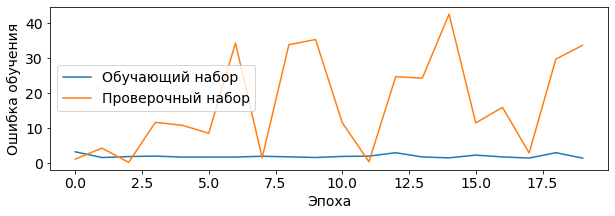

In [67]:
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']

fig, ax = plt.subplots(figsize=(10,3))
plt.rcParams.update({'font.size': 14})
plt.plot(range(epochs_num), train_loss, label='Обучающий набор')
plt.plot(range(epochs_num), val_loss, label='Проверочный набор')
plt.legend()
plt.xlabel('Эпоха')
plt.ylabel('Ошибка обучения')


#Saving results
image_name = f'figures/loss_NN.jpg'
# fig.savefig(image_name, format='jpg', dpi=110, bbox_inches='tight', pad_inches = 0.2)

In [68]:
model.evaluate(X_test, y_test)

# res = model.predict(x)


60/60 [==============================] - 0s 2ms/step - loss: 9.1398 - accuracy: 0.6579 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00


[9.139808654785156, 0.6578808426856995, 0.0, 0.0]

In [ ]:
# Распознавание всей тестовой выборки
pred = model.predict(x_test)
pred = np.argmax(pred, axis=1)

for i in range(len(pred)):
    if pred[i] == 2:
        pred[i] = 6

print(pred.shape)

print('Ответы\n', y_test[:30])
print('Предсказания\n', pred[:30])

In [ ]:
# Выделение неверных вариантов
mask = pred == y_new_test
# print(mask[:40])

# x_false = x_test[~mask]

# print(x_false.shape)

In [ ]:
# Вывод первых 25 неверных результатов
f, a = plt.subplots(figsize=(10, 5))
# f.suptitle('На каких картинках ошиблись')
# for i in range(25):
#     plt.subplot(5, 5, i+1)
#     plt.xticks([])
#     plt.yticks([])
#     plt.imshow(x_false[i], cmap=plt.cm.binary)

# target_names = ['0', 'Остальные цифры', '6']
# print(classification_report(y_new_test, pred, target_names=target_names))
# print(confusion_matrix(y_new_test, pred))

# plt.show()